In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit

from mne.decoding import CSP

current_directory = os.path.abspath('')

project_root = os.path.abspath(os.path.join(current_directory, '..'))

sys.path.append(project_root)

from Early_predict_UQ.data.make_dataset import make_data

def plot_over_time(w_times, class_balance, onset, scores_windows = None, confidence_windows = None):
    plt.figure()
    if (scores_windows != None):
        plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
        plt.axvline(onset, linestyle="--", color="k", label="Onset")
        plt.axhline(class_balance, linestyle="-", color="k", label="Chance")
        plt.xlabel("time (s)")
        plt.ylabel("classification accuracy")
        plt.title("Classification score over time")
        plt.legend(loc="lower right")
        plt.show()
    if (confidence_windows != None):
        plt.plot(w_times, np.mean(confidence_windows, 0), label="Score")
        plt.axvline(onset, linestyle="--", color="k", label="Onset")
        plt.axhline(0.5, linestyle="-", color="k", label="Threshold")
        plt.xlabel("time (s)")
        plt.ylabel("confidence")
        plt.title("Classification score over time")
        plt.legend(loc="lower right")
        plt.show()


subject_list = [1]
# Preprocessed epochs
epochs, labels = make_data(subject_list)
#epochs.plot()
#print("epochs shape: ",epochs.shape)
#print("labels shape: ",labels.shape)


<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
Choosing from all possible events


To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied


/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


In [ ]:
def calculate_entropy(probabilities):
    entropy = -np.sum(probabilities * np.log(probabilities))
    return entropy
def find_mean_probabilities(probabilities):
   return np.mean(probabilities, axis=0)

# Calculate maximum probability
def calculate_max_mean_probability_and_class(probabilities):
    max_mean_probability_index = np.argmax(np.mean(probabilities, axis=0))
    max_mean_probability = np.max(np.mean(probabilities, axis=0))
    corresponding_class = max_mean_probability_index + 1  # Classes are typically indexed starting from 1
    return max_mean_probability, corresponding_class

def most_frequent(List):
    counter = 0
    num = List[0]
     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num

threshold = 0.7


# Asserting the epochs and labels (last row of the events matrix) to be used for the classification
epochs_train = epochs.copy()
labels = epochs.events[:, -1] - 4

# Cross validation 
## (Might need to do cross session - session 1 as train, and session 2 as test. See dataset_structure.ipynb)
scores = []
epochs_data = epochs.get_data(copy=False)
print("len of epochs data:\n",len(epochs_data))
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)
print("cv split: \n", cv_split)

# LDA and CSP pipeline
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Class balance between the 4 classes. 
class_balance = np.zeros(4)
for i in range(4):
    class_balance[i] = np.mean(labels == i)

class_balance = np.max(class_balance)

sfreq = 250 # Sampling frequency of 250 Hz as per the BCI competion dataset 2a

# Classify the signal using a sliding window

w_length = int(sfreq * 0.5)  # Window length
w_step = int(sfreq * 0.1)  # window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step) # Set of starting positions in the signal(Note! the signal is 2s to 4s) 
#if len=0.5 and step = 0.1. Theres 36 starting points 0.1 s apart, multiplied by the sfreq
print("w start shape: ", w_start.shape)
print("w start: \n", w_start)
scores_windows = []  

#threshold = 0.5
confidence_windows = []
counter = 0
# Running classification across the signal
for train_idx, test_idx in cv_split:
    print("train idx: ", train_idx)
    print("test idx: ", test_idx)
    print("nr train_index:", len(train_idx))
    print("nr test_index:", len(test_idx))
    counter +=1
    y_train, y_test = labels[train_idx], labels[test_idx] # Get the current labels and data
    # Exatract spatial filters and transform the data as a whole
    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx]) #  why define it here!

    # Fit the classifier on the training data
    lda.fit(X_train, y_train)
    w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin


    #FIX THE STUFF LOL, IM TOO TIRED TO MAKE A PLAN 4 U BABES <33 LOVE U
    # Test the classifier on the windows. This is where we run over the signal
    score_this_window = []
    confidence_this_window = []
    max_classes = []
    num = 1
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
        probabilities = lda.predict_proba(X_test)
        print("prob shape: ", probabilities.shape)
        #print("probabilities: \n", probabilities)

        #print("prob means of the classes: \n ", find_mean_probabilities(probabilities))
        mean_probs = find_mean_probabilities(probabilities)

        #entropy = calculate_entropy(probabilities)
       
        confidence_this_window.append(mean_probs)

    #most_freq_max_class = most_frequent(max_classes)
    
    # Plot confidence 
    plt.plot(w_times, confidence_this_window, label = ["1","2","3","4"])
    plt.plot
    plt.xlabel("Time (s)")
    plt.ylabel("Confidence")
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    plt.axhline(0.5, linestyle="-", color="k", label="Threshold")
    plt.title("Classification Confidence over Time")
    plt.legend()
    plt.show()
    scores_windows.append(score_this_window)
    #print("right label:", y_test[?])
    if counter == 2:
        break

    '''plt.plot(w_times,mean_confidence_class_1, label="Confidence Class 1")
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    plt.axhline(0.5, linestyle="-", color="k", label="Threshold")
    plt.xlabel("time (s)")
    plt.ylabel("confidence")
    plt.title("Classification confidence over time")
    plt.legend(loc="lower right")
    plt.show()'''
   
    
# Plot the scores over time
#plot_over_time(w_times, class_balance, epochs.tmin, scores_windows, confidence_windows)

<h2> Sliding window with early stopping

In [31]:

import matplotlib.pyplot as plt
import numpy as np
import os
import sys

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from scipy.stats import entropy

from mne.decoding import CSP

current_directory = os.path.abspath('')

project_root = os.path.abspath(os.path.join(current_directory, '..'))

sys.path.append(project_root)

print("ROOT:", project_root)
from Early_predict_UQ.data.make_dataset import make_data
from Early_predict_UQ.data.plots import plot_accuracy_over_time_and_epochs, plot_confidence_over_time_and_epochs #, plot_cost_over_time_and_epochs

def early_pred(probabilities, predict, numTimesBelowThreshold, patience, confidence_type):
                probabilities = probabilities.flatten()
                sorted_probs = sorted(probabilities, reverse=True)
                #cost1 = 1/(1+(sorted_probs[0] - sorted_probs[1]))
                if confidence_type == 'highest_prob':
                    confidence = sorted_probs[0]
                else:
                    # confidence_type is 'two_highest_difference'
                    #Based on the stopping rule described in DOI: 10.1109/TNNLS.2017.2764939
                    confidence = 1/(1+(sorted_probs[0] + (sorted_probs[0] - sorted_probs[1])))
                if confidence > threshold and predict == False:
                    #print("Confidence reached")
                    numTimesBelowThreshold +=1
                    #print("numTimesBelowThreshold: ",numTimesBelowThreshold)
                    if numTimesBelowThreshold == patience:
                        predict = True
                return predict, confidence, numTimesBelowThreshold

# Setting hyper-parameters
threshold = 0.5 # need to be a list with values between 0 and 1 to loop over
patience = 4 # numTimesBelowThreshold - potential hyperparameter
current_person = 0
subjects = [1,2,3,4,5,6,7,8,9]  #all sucbjects
scores_across_subjects = [] 
prediction_time_across_subjects = []
confidence_across_subjects = []
for person in subjects:
    current_person += 1
    subject= [person] # Choosing the subject 

    # Preprocessed epochs
    epochs, labels = make_data(subject)

    # Asserting the epochs and labels (last row of the events matrix) to be used for the classification
    epochs_train = epochs.copy()
    labels = epochs.events[:, -1] - 4

    currentcv = 0
    current_epoch = 0
    current_window = 0
    # Cross validation 
    ## (Might need to do cross session - session 1 as train, and session 2 as test. See dataset_structure.ipynb)
    scores = []
    epochs_data = epochs.get_data(copy=False)
    epochs_data_train = epochs_train.get_data(copy=False)
    
    #Cross validation  (CV)
    cv = ShuffleSplit(10, test_size=0.2, random_state=42) #Potential hyperparameter.
    cv_split = cv.split(epochs_data_train)

    # Linear discriminant analysis (LDA) and Common Spatial Pattern (CSP)
    lda = LinearDiscriminantAnalysis() # classifier
    csp = CSP(n_components=5, reg=None, log=True, norm_trace=False) # why 4 components or 5 ? Potential hyperparameter.

    confidence_type = ['highest_prob', 'two_highest_difference']
    confidence_type = 'highest_prob' #Hyperparameter

    # Class balance between the 4 classes. 
    #This is a formality, as the dataset is balanced, with equal number epochs for each of the 4 classes.
    class_balance = np.zeros(4)
    for i in range(4):
        class_balance[i] = np.mean(labels == i)

    class_balance = np.max(class_balance)

    class_names = {
            1: "Left hand",
            2: "Right hand",
            3: "Both feet",
            4: "Tongue"
    }

    sfreq = 250 # Sampling frequency of 250 Hz as per the BCI competion dataset 2a

    # Classify the signal using a sliding window
    w_length = int(sfreq * 0.5)  # Window length - Hyperparameter.
    w_step = int(sfreq * 0.1)  # window step size - Hyperparameter.

    #if w_length = sfreq * 0.5 and w_step = sfreq * 0.1. Theres 36 starting points
    # Set of starting positions in the signal(Note! the signal is 2s to 4s) 
    w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step) 
    scores_cv_splits = [] 
    predict_time_cv_splits = []
    confidence_cv_split = []
    # Running classification across the signal
    for train_idx, test_idx in cv_split:
        currentcv+=1
        y_train, y_test = labels[train_idx], labels[test_idx] # Get the current labels and data

        # Exatract spatial filters and transform the data 
        X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
        X_test = csp.transform(epochs_data_train[test_idx]) #  why define and transform it here, and then do it later as well!

        # Fit the classifier on the training data
        lda.fit(X_train, y_train)
        w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin
        scores_across_epochs = []
        confidences_across_epochs = []
        predict_time_across_epochs = []
        current_epoch = 0     
        #The testset is 20% 116 epochs of the whole data 576 epochs(trials) for each subject
        for epoch_idx in range(len(test_idx)):  #for each epoch
            current_n = 0
            predict_time = 0
            current_epoch+=1
            predict = False 
            current_window = 0
            numTimesBelowThreshold = 0
            confidences_across_windows =[]
            for n in w_start: #for each sliding window
                current_window +=1 
                print(f" Subject {current_person} CV {currentcv}, epoch: {current_epoch}, and window:{current_window}")

                X_test_window = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
                X_test_epoch_window = X_test_window[epoch_idx]

                #Early prediction
                probabilities = lda.predict_proba([X_test_epoch_window])
                probabilities = np.array(probabilities)
                probabilities = probabilities.flatten()

                # predict becomes true to predict early then go to the next epoch
                predict, confidence, numTimesBelowThreshold = early_pred(probabilities, predict, numTimesBelowThreshold, patience, confidence_type)
                confidences_across_windows.append(confidence)
                if predict:
                    predict_time = n
                    print("early prediction")
                    score = lda.score(X_test_epoch_window.reshape(1, -1), [y_test[epoch_idx]])
                    break # predicting early
                current_n+=1
            else:
                predict_time = n #if not predicted early, we still predict as we have reached the end of the signal 
                score = lda.score(X_test_epoch_window.reshape(1, -1), [y_test[epoch_idx]])
                print("no early prediction in this epoch, numTimesBelowThreshold:", numTimesBelowThreshold)
            predict_time = (predict_time + w_length / 2.0) / sfreq + epochs.tmin
            scores_across_epochs.append(score)
            predict_time_across_epochs.append(predict_time)
    
        if currentcv == 1:
            scores_cv_splits = np.array(scores_across_epochs)
            predict_time_cv_splits = np.array(predict_time_across_epochs)
        else:
            scores_cv_splits = np.vstack((scores_cv_splits,np.array(scores_across_epochs)))
            predict_time_cv_splits = np.vstack((predict_time_cv_splits,np.array(predict_time_across_epochs)))

    mean_scores_across_cv = np.mean(scores_cv_splits, axis=0)
    mean_predict_time_across_cv = np.mean(predict_time_cv_splits, axis=0)
    if person == 1:
        scores_across_subjects  = np.array(mean_scores_across_cv)
        prediction_time_across_subjects = np.array(mean_predict_time_across_cv)
    else:
        scores_across_subjects = np.vstack((scores_across_subjects,np.array(mean_scores_across_cv)))
        prediction_time_across_subjects = np.vstack((predict_time_cv_splits,np.array(mean_predict_time_across_cv)))

mean_scores_across_subjects = np.mean(scores_across_subjects, axis=0)
accuracy = np.mean(mean_scores_across_subjects)
print("Classification accuracy: %f / Chance level: %f" % (accuracy, class_balance))
mean_prediction_time_across_subjects = np.mean(prediction_time_across_subjects, axis=0)
mean_prediction_time = np.mean(mean_prediction_time_across_subjects) -2
max_time = epochs.tmax-2
print("Mean prediction time: %f / full time: %f /  Percentage of time: %f" % (mean_prediction_time, max_time, mean_prediction_time/max_time))

''''
plt.plot(len(test_idx), mean_scores_across_cv, label="Score")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.axvline(2, linestyle="--", color="k", label="Onset")
plt.axhline(class_balance, linestyle="-", color="k", label="Chance")
plt.title("Classification accuracy over Time")
plt.legend()
plt.show()
'''
#print("scores_cv_splits (10X116?) shape:",scores_across_epochs
#print("predict_time_cv_splits (10X116?) shape: ", predict_time_across_epochs).shape

'''
To do - dynamic stop:
- sliding
    - make the for loops work and contain and provide the mean predict time and score correctly X
    - then advance to for all subjects X
    - modularize
    - the start the hyperparameter tuning to maximize classification accuracy, and minimize predict_time 
    - then loop across all threshold values 
    - make it take into account all the subjects
    - make it work using svm
    - provide the plots for all the subjects for all subjects for each condition, let it just save the plots to a folder automatically (potentially also the values to make plots somewhere else)
    - nb: watch the memory and time usage for codespaces
- expanding:
    - make a new file, adjust to use expanding window
    - save its plots into another folder automaically
            
To do - static:
- make a new file and adjust the dynamic to just use a specific predict times using the cost function
- save the plots

to do - whole:
- already did that lol

'''



'''
print("len w-times: ", w_times)
print("len w-start: ", w_start)
print("len w-times[:numberOfNs]: ", w_times[:numberOfNs])
print("len w-start[:numberOfNs]: ", w_start[:numberOfNs])
print("number n's ", numberOfNs)
'''

''' ##Costs for each of the classes for each window
plt.plot(w_times, confidences, label='Cost')
plt.xlabel("Time (s)")
plt.ylabel("Cost")
plt.axvline(w_times[predict_time], linestyle="-", color="b", label="Stopping")
plt.axvline(2, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Threshold")
plt.title("Cost over Time")
plt.legend()
plt.show()


##Accuracy for each window
plt.plot(w_times, score_this_window, label="Score")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.axvline(w_times[predict_time], linestyle="-", color="b", label="Stopping")
plt.axvline(2, linestyle="--", color="k", label="Onset")
plt.axhline(class_balance, linestyle="-", color="k", label="Chance")
plt.title("Classification accuracy over Time")
plt.legend()
plt.show()

plt.plot(w_times, confidence_this_window, label="Score")
plt.xlabel("Time (s)")
plt.ylabel("Confidence")
plt.ylim(0,1)
plt.axvline(w_times[predict_time], linestyle="-", color="b", label="Stopping")
plt.axvline(2, linestyle="--", color="k", label="Onset")
#plt.axhline(threshold, linestyle="-", color="k", label="Threshold")
plt.title("Model confindence over Time")
plt.legend()
plt.show()'''

'''
        
    #sanity check
    for epoch_idx in range(len(test_idx)): 
        current_n = 0
        current_epoch+=1
        predict = False 
        numTimesBelowThreshold = 0
        confidences_across_windows_full =[]
        probs_across_windows = []
        ##Earl pred
        for n in w_start:
            X_test_window = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
            X_test_epoch_window = X_test_window[epoch_idx+1]

            #Early prediction
            probabilities = lda.predict_proba([X_test_epoch_window])

            if len(probs_across_windows) == 0:
               probs_across_windows = probabilities
            else:
                probs_across_windows = np.vstack((probs_across_windows, probabilities))

            probabilities = np.array(probabilities)
            probabilities = probabilities.flatten()
            # predict becomes true to predict ealrly then go to the next epoch
            predict, confidence, numTimesBelowThreshold= early_pred(probabilities, predict, numTimesBelowThreshold, patience)
            confidences_across_windows_full.append(confidence)
            score = lda.score(X_test_epoch_window.reshape(1, -1), [y_test[epoch_idx+1]])
        plt.plot(w_times, confidences_across_windows_full, label='confidences_across_windows_full')
        plt.xlabel("Time (s)")
        plt.ylabel("confidence")
        plt.axvline(predict_time, linestyle="-", color="b", label="Stopping")
        plt.axvline(2, linestyle="--", color="k", label="Onset")
        plt.axhline(0.5, linestyle="-", color="k", label="Threshold")
        plt.title("Cost over Time")
        plt.legend()
        plt.show()
        y_test = y_test+4
        print("right label:", class_names[y_test[epoch_idx+1]])
            ##Probabiltiies for each of the classes for each window
        plt.plot(w_times, probs_across_windows, label=[class_names[label] for label in [1, 2, 3, 4]])
        plt.xlabel("Time (s)")
        plt.ylabel("Probabilities")
        plt.axvline(predict_time, linestyle="-", color="b", label="Stopping")
        plt.axvline(2, linestyle="--", color="k", label="Onset")
        plt.axhline(0.5, linestyle="-", color="k", label="Threshold")
        plt.title("Classification probabilities over Time")
        plt.legend()
        plt.show()
        break
    break
'''


Choosing from all possible events


ROOT: /workspaces/UQ_Early_prediction_MI_BCI
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied
Computing rank from data with rank=None


/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


    Using tolerance 3.3e-05 (2.2e-16 eps * 22 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7e-05 (2.2e-16 eps * 22 dim * 7.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7e-05 (2.2e-16 eps * 22 dim * 7.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank

Choosing from all possible events


early prediction
 Subject 1 CV 10, epoch: 109, and window:1
 Subject 1 CV 10, epoch: 109, and window:2
 Subject 1 CV 10, epoch: 109, and window:3
 Subject 1 CV 10, epoch: 109, and window:4
early prediction
 Subject 1 CV 10, epoch: 110, and window:1
 Subject 1 CV 10, epoch: 110, and window:2
 Subject 1 CV 10, epoch: 110, and window:3
 Subject 1 CV 10, epoch: 110, and window:4
 Subject 1 CV 10, epoch: 110, and window:5
early prediction
 Subject 1 CV 10, epoch: 111, and window:1
 Subject 1 CV 10, epoch: 111, and window:2
 Subject 1 CV 10, epoch: 111, and window:3
 Subject 1 CV 10, epoch: 111, and window:4
early prediction
 Subject 1 CV 10, epoch: 112, and window:1
 Subject 1 CV 10, epoch: 112, and window:2
 Subject 1 CV 10, epoch: 112, and window:3
 Subject 1 CV 10, epoch: 112, and window:4
early prediction
 Subject 1 CV 10, epoch: 113, and window:1
 Subject 1 CV 10, epoch: 113, and window:2
 Subject 1 CV 10, epoch: 113, and window:3
 Subject 1 CV 10, epoch: 113, and window:4
early predic

/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


    Using tolerance 5.4e-05 (2.2e-16 eps * 22 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.9e-05 (2.2e-16 eps * 22 dim * 1e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5e-05 (2.2e-16 eps * 22 dim * 1e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.8e-05 (2.2e-16 eps * 22 dim * 9.7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 

Choosing from all possible events


 Subject 2 CV 10, epoch: 106, and window:2
 Subject 2 CV 10, epoch: 106, and window:3
 Subject 2 CV 10, epoch: 106, and window:4
early prediction
 Subject 2 CV 10, epoch: 107, and window:1
 Subject 2 CV 10, epoch: 107, and window:2
 Subject 2 CV 10, epoch: 107, and window:3
 Subject 2 CV 10, epoch: 107, and window:4
early prediction
 Subject 2 CV 10, epoch: 108, and window:1
 Subject 2 CV 10, epoch: 108, and window:2
 Subject 2 CV 10, epoch: 108, and window:3
 Subject 2 CV 10, epoch: 108, and window:4
 Subject 2 CV 10, epoch: 108, and window:5
 Subject 2 CV 10, epoch: 108, and window:6
 Subject 2 CV 10, epoch: 108, and window:7
 Subject 2 CV 10, epoch: 108, and window:8
 Subject 2 CV 10, epoch: 108, and window:9
 Subject 2 CV 10, epoch: 108, and window:10
 Subject 2 CV 10, epoch: 108, and window:11
 Subject 2 CV 10, epoch: 108, and window:12
 Subject 2 CV 10, epoch: 108, and window:13
 Subject 2 CV 10, epoch: 108, and window:14
 Subject 2 CV 10, epoch: 108, and window:15
 Subject 2 CV 

/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


    Using tolerance 4.4e-05 (2.2e-16 eps * 22 dim * 9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-05 (2.2e-16 eps * 22 dim * 9.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5e-05 (2.2e-16 eps * 22 dim * 1e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.2e-05 (2.2e-16 eps * 22 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 

Choosing from all possible events


early prediction
 Subject 3 CV 10, epoch: 108, and window:1
 Subject 3 CV 10, epoch: 108, and window:2
 Subject 3 CV 10, epoch: 108, and window:3
 Subject 3 CV 10, epoch: 108, and window:4
early prediction
 Subject 3 CV 10, epoch: 109, and window:1
 Subject 3 CV 10, epoch: 109, and window:2
 Subject 3 CV 10, epoch: 109, and window:3
 Subject 3 CV 10, epoch: 109, and window:4
early prediction
 Subject 3 CV 10, epoch: 110, and window:1
 Subject 3 CV 10, epoch: 110, and window:2
 Subject 3 CV 10, epoch: 110, and window:3
 Subject 3 CV 10, epoch: 110, and window:4
early prediction
 Subject 3 CV 10, epoch: 111, and window:1
 Subject 3 CV 10, epoch: 111, and window:2
 Subject 3 CV 10, epoch: 111, and window:3
 Subject 3 CV 10, epoch: 111, and window:4
early prediction
 Subject 3 CV 10, epoch: 112, and window:1
 Subject 3 CV 10, epoch: 112, and window:2
 Subject 3 CV 10, epoch: 112, and window:3
 Subject 3 CV 10, epoch: 112, and window:4
early prediction
 Subject 3 CV 10, epoch: 113, and wind

/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


Done.
Computing rank from data with rank=None
    Using tolerance 3.2e-05 (2.2e-16 eps * 22 dim * 6.6e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
 Subject 4 CV 1, epoch: 1, and window:1
 Subject 4 CV 1, epoch: 1, and window:2
 Subject 4 CV 1, epoch: 1, and wind

Choosing from all possible events


 Subject 4 CV 10, epoch: 115, and window:7
 Subject 4 CV 10, epoch: 115, and window:8
early prediction
 Subject 4 CV 10, epoch: 116, and window:1
 Subject 4 CV 10, epoch: 116, and window:2
 Subject 4 CV 10, epoch: 116, and window:3
 Subject 4 CV 10, epoch: 116, and window:4
early prediction
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied
Computing rank from data with rank=None


/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


    Using tolerance 3.1e-05 (2.2e-16 eps * 22 dim * 6.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.1e-05 (2.2e-16 eps * 22 dim * 6.3e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.1e-05 (2.2e-16 eps * 22 dim * 6.4e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3e-05 (2.2e-16 eps * 22 dim * 6.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank

Choosing from all possible events


 Subject 5 CV 10, epoch: 111, and window:7
early prediction
 Subject 5 CV 10, epoch: 112, and window:1
 Subject 5 CV 10, epoch: 112, and window:2
 Subject 5 CV 10, epoch: 112, and window:3
 Subject 5 CV 10, epoch: 112, and window:4
 Subject 5 CV 10, epoch: 112, and window:5
 Subject 5 CV 10, epoch: 112, and window:6
 Subject 5 CV 10, epoch: 112, and window:7
 Subject 5 CV 10, epoch: 112, and window:8
 Subject 5 CV 10, epoch: 112, and window:9
 Subject 5 CV 10, epoch: 112, and window:10
 Subject 5 CV 10, epoch: 112, and window:11
 Subject 5 CV 10, epoch: 112, and window:12
 Subject 5 CV 10, epoch: 112, and window:13
 Subject 5 CV 10, epoch: 112, and window:14
 Subject 5 CV 10, epoch: 112, and window:15
 Subject 5 CV 10, epoch: 112, and window:16
 Subject 5 CV 10, epoch: 112, and window:17
 Subject 5 CV 10, epoch: 112, and window:18
 Subject 5 CV 10, epoch: 112, and window:19
 Subject 5 CV 10, epoch: 112, and window:20
 Subject 5 CV 10, epoch: 112, and window:21
 Subject 5 CV 10, epoch: 

/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


    Using tolerance 4.4e-05 (2.2e-16 eps * 22 dim * 9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-05 (2.2e-16 eps * 22 dim * 9.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.1e-05 (2.2e-16 eps * 22 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.7e-05 (2.2e-16 eps * 22 dim * 9.7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank

Choosing from all possible events


 Subject 6 CV 10, epoch: 110, and window:2
 Subject 6 CV 10, epoch: 110, and window:3
 Subject 6 CV 10, epoch: 110, and window:4
early prediction
 Subject 6 CV 10, epoch: 111, and window:1
 Subject 6 CV 10, epoch: 111, and window:2
 Subject 6 CV 10, epoch: 111, and window:3
 Subject 6 CV 10, epoch: 111, and window:4
early prediction
 Subject 6 CV 10, epoch: 112, and window:1
 Subject 6 CV 10, epoch: 112, and window:2
 Subject 6 CV 10, epoch: 112, and window:3
 Subject 6 CV 10, epoch: 112, and window:4
early prediction
 Subject 6 CV 10, epoch: 113, and window:1
 Subject 6 CV 10, epoch: 113, and window:2
 Subject 6 CV 10, epoch: 113, and window:3
 Subject 6 CV 10, epoch: 113, and window:4
 Subject 6 CV 10, epoch: 113, and window:5
early prediction
 Subject 6 CV 10, epoch: 114, and window:1
 Subject 6 CV 10, epoch: 114, and window:2
 Subject 6 CV 10, epoch: 114, and window:3
 Subject 6 CV 10, epoch: 114, and window:4
early prediction
 Subject 6 CV 10, epoch: 115, and window:1
 Subject 6 C

/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.3e-05 (2.2e-16 eps * 22 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 6.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
 Subject 7 CV 1, epoch: 1, and window:1
 Sub

Choosing from all possible events


 Subject 7 CV 10, epoch: 109, and window:2
 Subject 7 CV 10, epoch: 109, and window:3
 Subject 7 CV 10, epoch: 109, and window:4
early prediction
 Subject 7 CV 10, epoch: 110, and window:1
 Subject 7 CV 10, epoch: 110, and window:2
 Subject 7 CV 10, epoch: 110, and window:3
 Subject 7 CV 10, epoch: 110, and window:4
 Subject 7 CV 10, epoch: 110, and window:5
early prediction
 Subject 7 CV 10, epoch: 111, and window:1
 Subject 7 CV 10, epoch: 111, and window:2
 Subject 7 CV 10, epoch: 111, and window:3
 Subject 7 CV 10, epoch: 111, and window:4
early prediction
 Subject 7 CV 10, epoch: 112, and window:1
 Subject 7 CV 10, epoch: 112, and window:2
 Subject 7 CV 10, epoch: 112, and window:3
 Subject 7 CV 10, epoch: 112, and window:4
 Subject 7 CV 10, epoch: 112, and window:5
early prediction
 Subject 7 CV 10, epoch: 113, and window:1
 Subject 7 CV 10, epoch: 113, and window:2
 Subject 7 CV 10, epoch: 113, and window:3
 Subject 7 CV 10, epoch: 113, and window:4
early prediction
 Subject 7 C

/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


    Using tolerance 5.9e-05 (2.2e-16 eps * 22 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6e-05 (2.2e-16 eps * 22 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-05 (2.2e-16 eps * 22 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.3e-05 (2.2e-16 eps * 22 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank

Choosing from all possible events


 Subject 8 CV 10, epoch: 107, and window:3
 Subject 8 CV 10, epoch: 107, and window:4
early prediction
 Subject 8 CV 10, epoch: 108, and window:1
 Subject 8 CV 10, epoch: 108, and window:2
 Subject 8 CV 10, epoch: 108, and window:3
 Subject 8 CV 10, epoch: 108, and window:4
early prediction
 Subject 8 CV 10, epoch: 109, and window:1
 Subject 8 CV 10, epoch: 109, and window:2
 Subject 8 CV 10, epoch: 109, and window:3
 Subject 8 CV 10, epoch: 109, and window:4
early prediction
 Subject 8 CV 10, epoch: 110, and window:1
 Subject 8 CV 10, epoch: 110, and window:2
 Subject 8 CV 10, epoch: 110, and window:3
 Subject 8 CV 10, epoch: 110, and window:4
early prediction
 Subject 8 CV 10, epoch: 111, and window:1
 Subject 8 CV 10, epoch: 111, and window:2
 Subject 8 CV 10, epoch: 111, and window:3
 Subject 8 CV 10, epoch: 111, and window:4
early prediction
 Subject 8 CV 10, epoch: 112, and window:1
 Subject 8 CV 10, epoch: 112, and window:2
 Subject 8 CV 10, epoch: 112, and window:3
 Subject 8 C

/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


    Using tolerance 5.5e-05 (2.2e-16 eps * 22 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e-05 (2.2e-16 eps * 22 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.2e-05 (2.2e-16 eps * 22 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.1e-05 (2.2e-16 eps * 22 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 22
    MAG: ra

'\n        \n    #sanity check\n    for epoch_idx in range(len(test_idx)): \n        current_n = 0\n        current_epoch+=1\n        predict = False \n        numTimesBelowThreshold = 0\n        confidences_across_windows_full =[]\n        probs_across_windows = []\n        ##Earl pred\n        for n in w_start:\n            X_test_window = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])\n            X_test_epoch_window = X_test_window[epoch_idx+1]\n\n            #Early prediction\n            probabilities = lda.predict_proba([X_test_epoch_window])\n\n            if len(probs_across_windows) == 0:\n               probs_across_windows = probabilities\n            else:\n                probs_across_windows = np.vstack((probs_across_windows, probabilities))\n\n            probabilities = np.array(probabilities)\n            probabilities = probabilities.flatten()\n            # predict becomes true to predict ealrly then go to the next epoch\n            predict, confidenc

<h2>Increasing window instead

Choosing from all possible events


Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied
shape of epochs data:
 (576, 22, 1001)
cv split: 
 <generator object BaseShuffleSplit.split at 0x7dfe59bff440>
w start shape:  (36,)
nr train_index: 460
nr test_index: 116
Computing rank from data with rank=None


/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


    Using tolerance 3.3e-05 (2.2e-16 eps * 22 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4e-05 (2.2e-16 eps * 22 dim * 7e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7e-05 (2.2e-16 eps * 22 dim * 7.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7e-05 (2.2e-16 eps * 22 dim * 7.5e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank

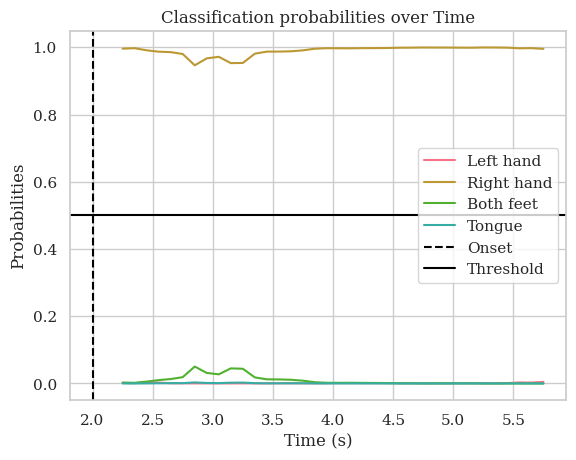

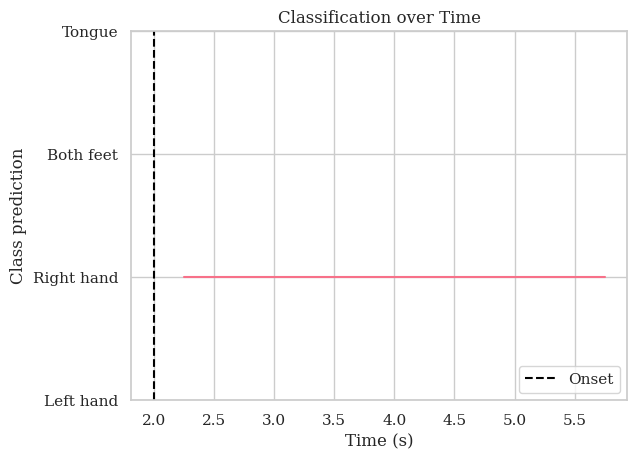

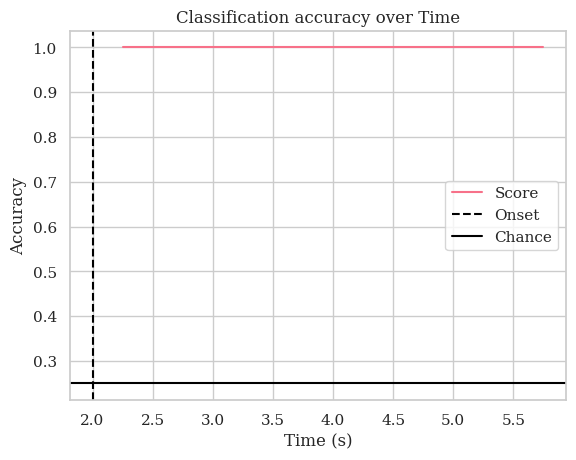

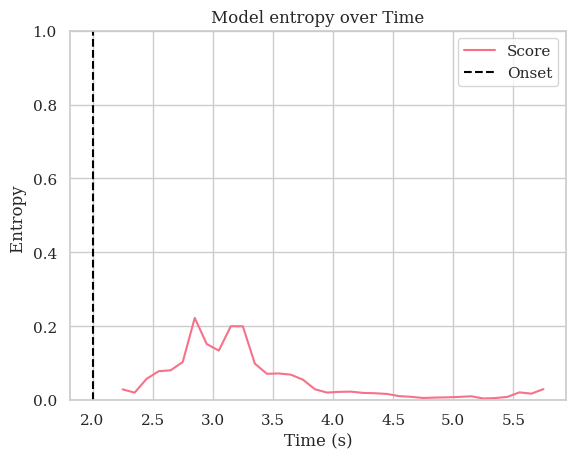

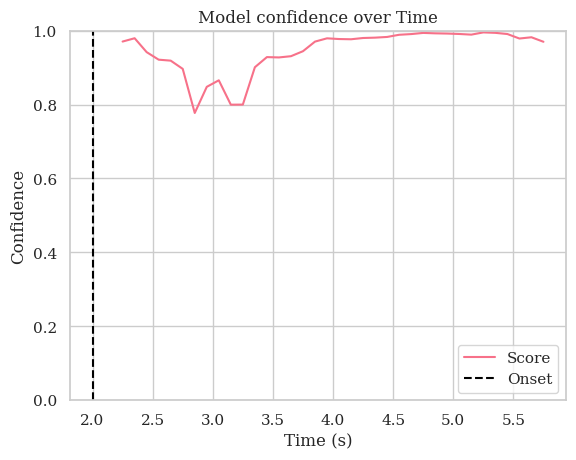

right label: Right hand


In [2]:

#Want to look at 1 epoch only, not all epochs in the test idx at the given sliding window
import scipy
from scipy.stats import entropy

def calculate_entropy(probabilities):
    entropy = -np.sum(probabilities * np.log(probabilities))
    return entropy

def find_mean_probabilities(probabilities):
   return np.mean(probabilities, axis=0)

def calculate_max_mean_probability_and_class(probabilities):
    max_mean_probability_index = np.argmax(np.mean(probabilities, axis=0))
    max_mean_probability = np.max(np.mean(probabilities, axis=0))
    corresponding_class = max_mean_probability_index + 1  # Classes are typically indexed starting from 1
    return max_mean_probability, corresponding_class

def most_frequent(List):
    counter = 0
    num = List[0]
     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num

threshold = 0.7

subject_list = [1] # Choosing the subject or subjects
# Preprocessed epochs
epochs, labels = make_data(subject_list)
# Asserting the epochs and labels (last row of the events matrix) to be used for the classification
epochs_train = epochs.copy()
labels = epochs.events[:, -1] - 4

# Cross validation 
## (Might need to do cross session - session 1 as train, and session 2 as test. See dataset_structure.ipynb)
scores = []
epochs_data = epochs.get_data(copy=False)
print("shape of epochs data:\n",epochs_data.shape)
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)
print("cv split: \n", cv_split)

# LDA and CSP pipeline
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=5, reg=None, log=True, norm_trace=False) # why 4 components or 5

# Class balance between the 4 classes. 
class_balance = np.zeros(4)
for i in range(4):
    class_balance[i] = np.mean(labels == i)

class_balance = np.max(class_balance)

sfreq = 250 # Sampling frequency of 250 Hz as per the BCI competion dataset 2a

# Classify the signal using a growing window
# Define initial window parameters
initial_window_length = int(sfreq * 0.5)  # Initial window length
w_step = int(sfreq * 0.1)  # Window step size
w_start = np.arange(0, epochs_data.shape[2] - initial_window_length, w_step)  # Set of starting positions in the signal (Note! the signal is 2s to 4s)

print("w start shape: ", w_start.shape)
#print("w start: \n", w_start)
scores_windows = [] 
#threshold = 0.5
entropy_windows = []
# Running classification across the signal
for train_idx, test_idx in cv_split:
    #print("train idx: ", train_idx)
    #print("test idx: ", test_idx)
    print("nr train_index:", len(train_idx))
    print("nr test_index:", len(test_idx))
    y_train, y_test = labels[train_idx], labels[test_idx] # Get the current labels and data
    # Exatract spatial filters and transform the data as a whole
    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx]) #  why define and transform it here, and then do it later as well!

    # Fit the classifier on the training data
    lda.fit(X_train, y_train)
    w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin



    # Test the classifier on the windows. This is where we run over the signal
    preds_this_window = []
    probs_this_window = []
    score_this_window = []
    entropy_this_window = []
    confidence_this_window = []
    chosen_epoch = 18 #Choose an epoch between 1 and 116. As the testset is 20% 116 epochs of the whole data 576 epochs
    for n, window_start in enumerate(w_start):
        window_length = initial_window_length + n * w_step
        X_test  = csp.transform(epochs_data[test_idx][:, :, window_start:(window_start + window_length)])
        print("X_test  shape:\n",X_test.shape)
        X_test_1_epoch = X_test [chosen_epoch] #Chooosing a specific epoch in the test set 
        print("X_test_1_epoch shape:\n", X_test_1_epoch.shape)

        #Accuracy
        score = lda.score(X_test_1_epoch.reshape(1, -1), [y_test[chosen_epoch]])
        score_this_window.append(score)
        
        probabilities = lda.predict_proba([X_test_1_epoch])
        
        if len(probs_this_window) == 0:
            probs_this_window = probabilities
        else:
            probs_this_window = np.vstack((probs_this_window, probabilities))

        prediction = lda.predict([X_test_1_epoch])
        preds_this_window.append(prediction)

        print("Prediction for this time window: ", prediction)
        print("prob shape: ", probabilities.shape)
        print("probabilities: \n", probabilities)

        #predictive entropy - H_pred(p) 
        entropy_score = entropy(probabilities, axis = 1) #- see if entropy is better than probabilites
        entropy_this_window.append(entropy_score)

        '''
        Confidence - as seen in: 
        Uncertainty Quantification in Machine Learning for Biosignal Applications - A Review, page 13.
        1 - H_pred(p) can be used as a confidence measure. Normalizing seems useful - 1 / (1- entropy-score)
        '''
        #confidence
        confidence = 1 - entropy_score
        confidence_this_window.append(confidence)

    class_names = {
        1: "Left hand",
        2: "Right hand",
        3: "Both feet",
        4: "Tongue"
    }

    ##Probabiltiies for each of the classes for each window
    plt.plot(w_times, probs_this_window, label=[class_names[label] for label in [1, 2, 3, 4]])
    plt.xlabel("Time (s)")
    plt.ylabel("Probabilities")
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    plt.axhline(0.5, linestyle="-", color="k", label="Threshold")
    plt.title("Classification probabilities over Time")
    plt.legend()
    plt.show()

    ##Predictions for each window
    preds_this_window_plottable = [x+4 for x in preds_this_window]
    plt.plot(w_times, preds_this_window_plottable)
    plt.xlabel("Time (s)")
    plt.ylabel("Class prediction")
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    plt.title("Classification over Time")
    plt.yticks([1, 2, 3, 4], [class_names[label] for label in [1, 2, 3, 4]])
    plt.legend(loc="lower right")
    plt.show()
    plt.show()

    ##Accuracy for each window
    plt.plot(w_times, score_this_window, label="Score")
    plt.xlabel("Time (s)")
    plt.ylabel("Accuracy")
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    plt.axhline(class_balance, linestyle="-", color="k", label="Chance")
    plt.title("Classification accuracy over Time")
    plt.legend()
    plt.show()

    ##Entropy for each window 
    plt.plot(w_times, entropy_this_window, label="Score")
    plt.xlabel("Time (s)")
    plt.ylabel("Entropy ")
    plt.ylim(0,1)
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    plt.title("Model entropy over Time")
    plt.legend()
    plt.show()

    plt.plot(w_times, confidence_this_window, label="Score")
    plt.xlabel("Time (s)")
    plt.ylabel("Confidence")
    plt.ylim(0,1)
    plt.axvline(2, linestyle="--", color="k", label="Onset")
    #plt.axhline(threshold, linestyle="-", color="k", label="Threshold")
    plt.title("Model confidence over Time")
    plt.legend()
    plt.show()


    y_test = y_test+4
    print("right label:", class_names[y_test[chosen_epoch]])
    break
   
